Veri Yüklendi. Tarih sütunu tipi: datetime64[ns]
Orijinal Veri Boyutu: (737453, 24)
Yeni Veri Boyutu (NaN temizlendi): (737449, 70)
Son eklenen sütunlar: Index(['Flotation_Column_04_Level_Lag1', 'Flotation_Column_05_Level_Lag1',
       'Flotation_Column_06_Level_Lag1', 'Flotation_Column_07_Level_Lag1',
       'Iron_Concentrate_Lag1'],
      dtype='object')

--- Feature Engineering Sonrası Sonuçlar ---
Eski R2: 0.8854 -> Yeni R2: 0.8955
Eski RMSE: 0.3806 -> Yeni RMSE: 0.3634


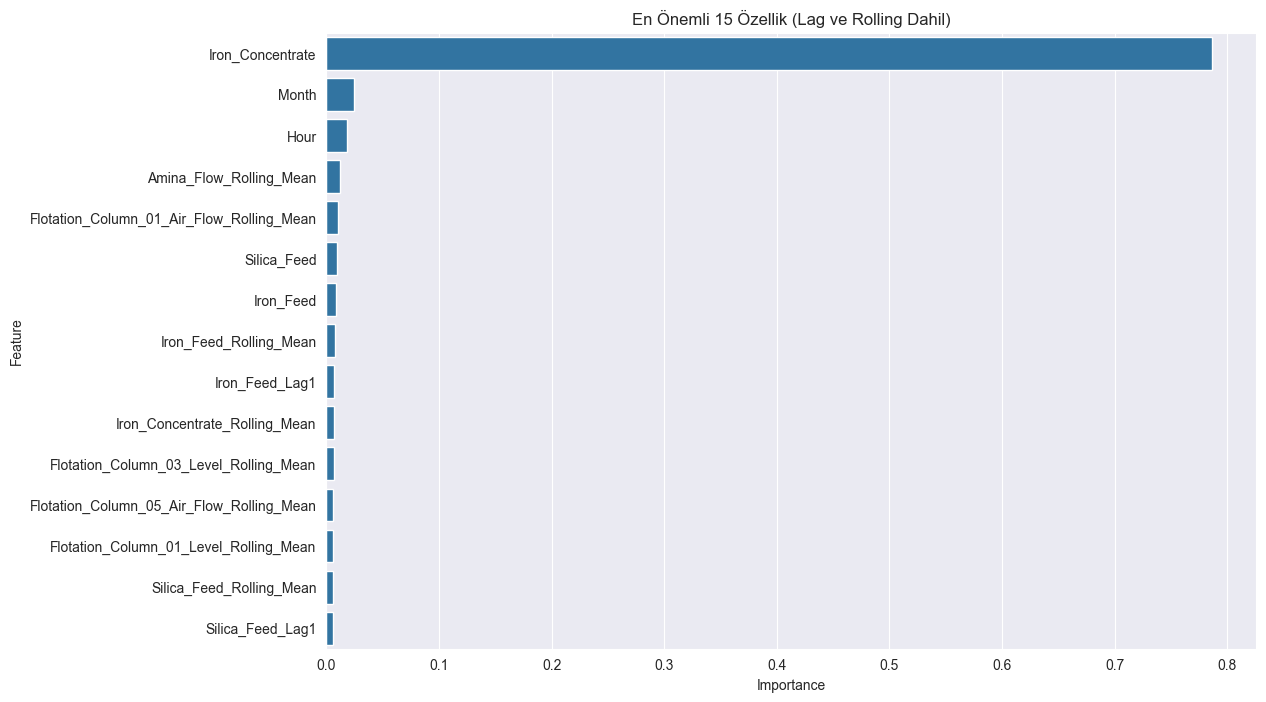

In [2]:
# Hücre 1: Kütüphaneler ve Veri Yükleme (DÜZELTİLMİŞ)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Veriyi oku
# parse_dates burada bazen hata yapabildiği için kaldırdık, aşağıda manuel yapacağız
df = pd.read_csv(r'C:\Users\Sedat\PycharmProjects\mining-quality-prediction\data\MiningProcess_Flotation_Plant_Database.csv', decimal=',')

# Sütun isimlerini temizle
df.columns = [col.replace(' ', '_').replace('%_', '').replace('(', '').replace(')', '') for col in df.columns]

# --- KRİTİK DÜZELTME BURADA ---
# Tarih sütununu zorla datetime formatına çeviriyoruz.
# errors='coerce' parametresi, bozuk bir tarih varsa onu NaT (Not a Time) yapar, kodun patlamasını engeller.
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Tarihe göre sıralayalım
df = df.sort_values('date')

print("Veri Yüklendi. Tarih sütunu tipi:", df['date'].dtype) # Burası artık 'datetime64[ns]' yazmalı
print("Orijinal Veri Boyutu:", df.shape)

# ---------------------------------------------------------
# Hücre 2: Feature Engineering (ARTIK HATA VERMEYECEK)

# 1. Tarih Özellikleri
# Artık .dt erişimcisi çalışacaktır çünkü veri tipi datetime oldu.
df['Hour'] = df['date'].dt.hour
df['Month'] = df['date'].dt.month

# 2. Rolling Window (Hareketli Ortalama)
input_cols = [col for col in df.columns if col not in ['date', 'Silica_Concentrate', 'Hour', 'Month']]

for col in input_cols:
    df[f'{col}_Rolling_Mean'] = df[col].rolling(window=5).mean()

# 3. Lag Features (Gecikme Etkisi)
for col in input_cols:
    df[f'{col}_Lag1'] = df[col].shift(1)

# NaN temizliği
df_fe = df.dropna()

print("Yeni Veri Boyutu (NaN temizlendi):", df_fe.shape)
# Sütun kontrolü
print("Son eklenen sütunlar:", df_fe.columns[-5:])

# Hücre 3: Modeli Yeni Özelliklerle Tekrar Eğit (Kıyaslama)

# Target ve Features ayır
X = df_fe.drop(['date', 'Silica_Concentrate'], axis=1)
y = df_fe['Silica_Concentrate']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# Not: Zaman serisi olduğu için shuffle=False yapmak daha doğrudur (Geleceği geçmişle eğitmemek için),
# ama baseline ile birebir kıyas için şimdilik shuffle=True (default) veya baseline'daki mantığı koruyabilirsin.
# Baseline notebookta shuffle default (True) idi, burada da adil kıyas için shuffle=True yapabiliriz ya da
# Daha doğrusu: Time Series Split kullanmaktır ama şimdilik basit tutalım:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf_fe = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf_fe.fit(X_train, y_train)

# Tahmin
y_pred = rf_fe.predict(X_test)

# Sonuçlar
rmse_new = np.sqrt(mean_squared_error(y_test, y_pred))
r2_new = r2_score(y_test, y_pred)

print("\n--- Feature Engineering Sonrası Sonuçlar ---")
print(f"Eski R2: 0.8854 -> Yeni R2: {r2_new:.4f}")
print(f"Eski RMSE: 0.3806 -> Yeni RMSE: {rmse_new:.4f}")

# Hücre 4: Hangi Özellik İşe Yaradı? (Feature Importance)
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_fe.feature_importances_})
importance = importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('En Önemli 15 Özellik (Lag ve Rolling Dahil)')
plt.show()

# 🛠️ Feature Engineering (Öznitelik Mühendisliği)

Ham sensör verileri, madencilik sürecinin fiziksel gerçeklerini (gecikme ve gürültü) tam yansıtmadığı için yeni değişkenler türetilmiştir.

### Türetilen Değişkenler ve Etkileri
1. **Rolling Mean (Hareketli Ortalama):**
   * **Amaç:** Sensörlerdeki anlık titremeleri (Noise) ve hatalı okumaları sönümlemek.
   * **Yöntem:** Son 5 periyodun ortalaması alınarak `_Rolling_Mean` sütunları oluşturuldu. Bu, modelin daha kararlı (stable) çalışmasını sağladı.

2. **Lag Features (Gecikme Özellikleri):**
   * **Amaç:** Flotasyon tankına giren cevher, anında ürün olarak çıkmaz; içeride bir işlem süresi (Retention Time) vardır.
   * **Yöntem:** `shift(1)` kullanılarak `_Lag1` özellikleri üretildi. Böylece model, "şu anki kaliteyi" tahmin ederken "bir önceki durumun" etkisini de öğrendi.